In [ ]:
import matplotlib.pyplot as plt

import PIL as pil
import PIL.Image as Im

import numpy as np

# Data loading

Image Size: (672, 672)
Image data dimensions: (451584, 3)


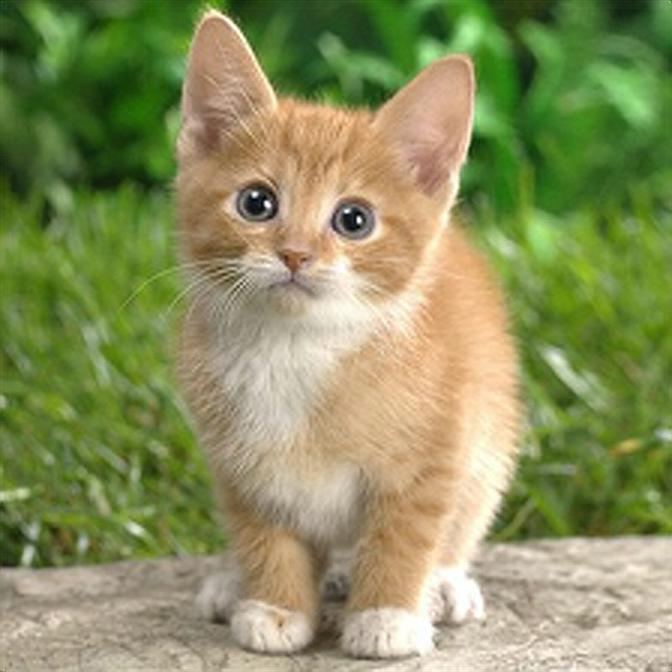

In [ ]:
sample = Im.open('/content/sample.jpg')
print(f'Image Size: {sample.size}')
print(f'Image data dimensions: {np.array(sample.getdata()).shape}')
sample # Note that because colab is a bij so sample.show() wont work

Notice that when converted into an array, the dimensions seem off  
Hence we need to convert into 672x672x3

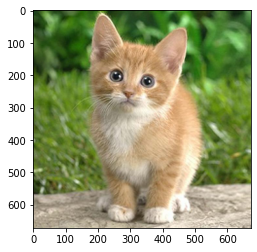

In [ ]:
data = np.array(sample.getdata())
data = data.reshape(sample.width, sample.height, 3)

plt.imshow(data) # Once again check if everything is done properly

Note that in this example I use a jpg image because I am lazy. Hence my data has dimensions (width, height, 3)  

However note that other file formats can have different dimensions.  
E.g: png images tend to have 4 channels (last dimension is 4) since they have rgba instead of rgb channels for colour  

Hence always check the data u use before proceeding with any sort of augmentation or preprocessing

# Basics

Before we proceed with augmentation, we want to ensure that any result we have will be the same size.  

In [ ]:
target_width = 224
target_height = 224

## Cropping

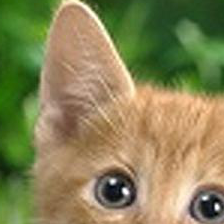

In [ ]:
top = np.random.rand() * (sample.height - target_height)
bottom = top + target_height
left = np.random.rand() * (sample.width - target_width)
right = left + target_width


# don't bother trying to rmb this order. Just google every time lol
sample.crop((left, top, right, bottom))

Ok so notice how this method kinda sucks cause it crops just about everywhere  

There are better method out there for cropping (e.g torchvision.transforms.CenterCrop) but we won't have time to cover them all

## Flips and rotations

Use the .transpose() method for flipping

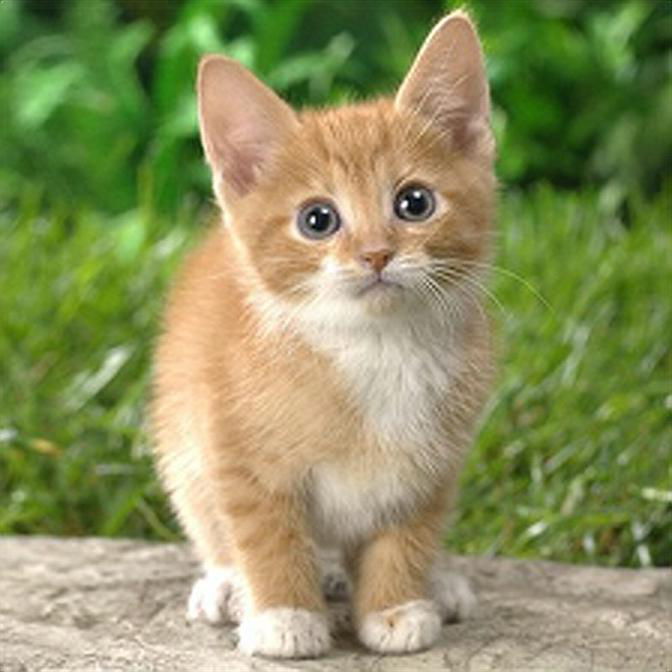

In [ ]:
sample.transpose(Im.FLIP_LEFT_RIGHT)

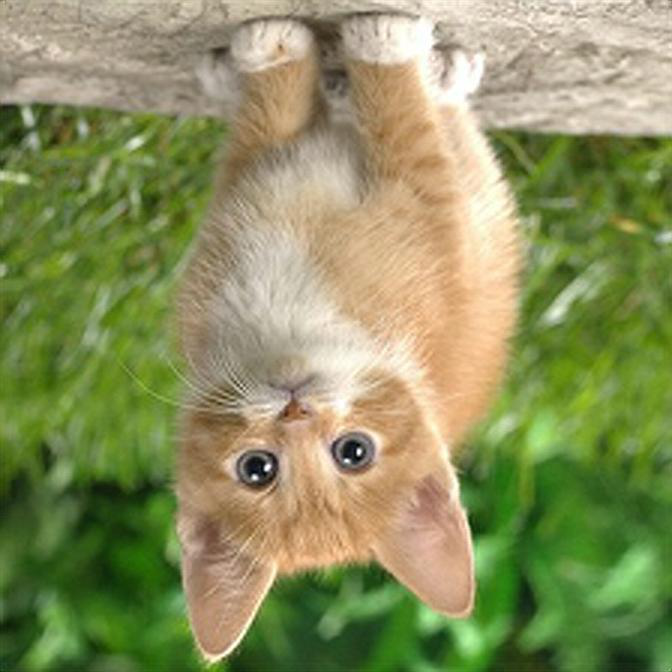

In [ ]:
sample.transpose(Im.FLIP_TOP_BOTTOM)

Rotations are done using the .rotate() method (duh)

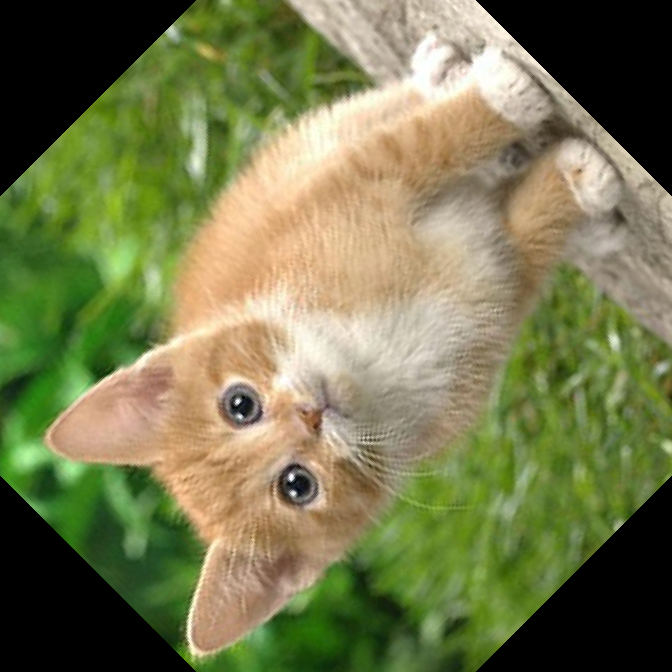

In [ ]:
angle = 135

sample.rotate(angle)

Notice that PIL handles the trimming and reshaping of the rotated image for u so it still has the same dimensions so it ends up with the black areas (padding)

Hence note that if u wanna apply rotations, proceed with caution and rmb to crop afterwards

## Padding

Generally there are 2 kinds of padding.

1. Pad with a single colour (usually black or white)
2. Pad using the image itself

For this part we'll work with a smaller version of the image

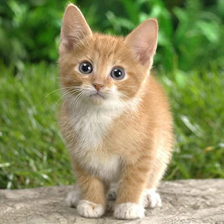

In [ ]:
sample_smol = sample.resize((target_width, target_height))
sample_smol

One possible way of padding is to directly edit the array retrieved from .getdata()

However because that method is extremely cumbersome and I am lazy, let's look at a simpler method first

In [ ]:
from PIL import ImageOps

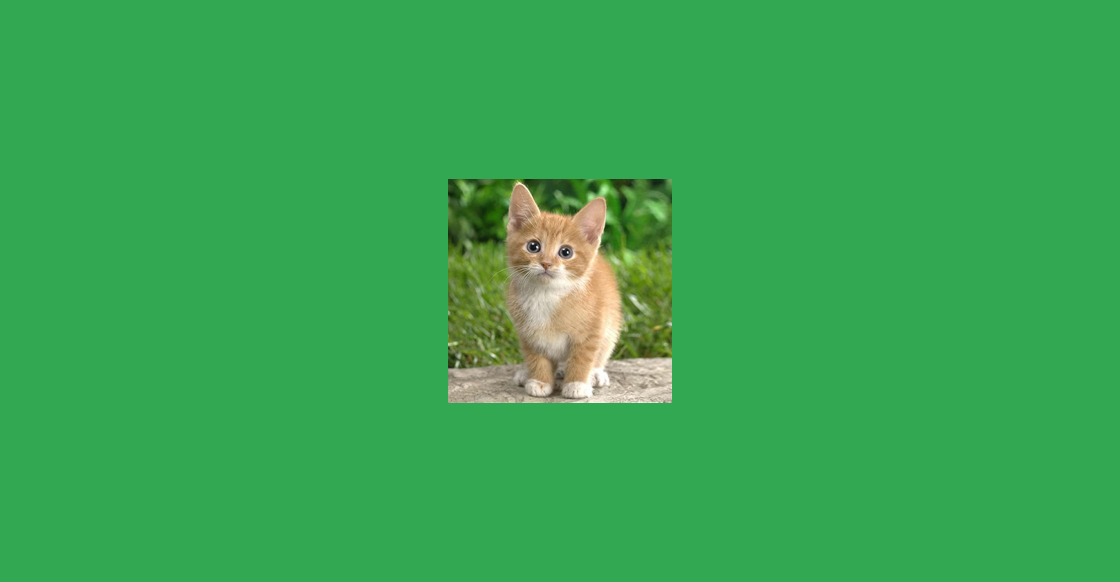

In [ ]:
ImageOps.expand(sample_smol, border=(target_width*2, round(target_height*0.8)), fill=(50, 168, 82))

To pad an image with itself, for some reason it's easier to use numpy than any other image processing library lol  
(NOTE: torch functional provides a pad() function but had some issues with colab environment)

In [ ]:
data_smol = np.array(sample_smol.getdata())
data_smol = np.array(data_smol.reshape(sample_smol.width, sample_smol.height, data_smol.shape[-1]))
data_smol.shape

(224, 224, 3)

(224, 448, 3)


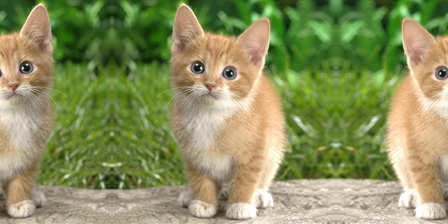

In [ ]:
width_padding = (target_width*2 - sample_smol.width) // 2
height_padding = (target_height - sample_smol.height) // 2

smol_padded = np.pad(sample_smol, pad_width=((height_padding, height_padding), 
                                             (width_padding, width_padding), 
                                             (0, 0)), # Note that the channel dimension should never be padded
                     mode='symmetric')
print(smol_padded.shape)
Im.fromarray(smol_padded)

Note that this augmentation will be extremely harmful if your data has bounding boxes

There are many things you can do to an image. Pretty much anything that can be done in photoshop can be used as a tool for data augmentation.  

However, the most important thing is to still inspect your augmented data and make sure that it still makes sense in the context of your training object  
(e.g: don't greyscale an image if u want your model to learn about colours or dont blur the image if u want it to learn fine details)

# Mixup

The goal of [mixup](https://arxiv.org/pdf/1710.09412.pdf) is to literally mix up different samples.  
Formally, for samples $x_i, x_j$ with labels $y_i, y_j$ respectively,  
if $i\neq{j}$  
> $\hat{x}= {\lambda}x_i + (1 - {\lambda})x_j$  
> $\hat{y}= {\lambda}y_i + (1 - {\lambda})y_j$  

Where $\hat{x}, \hat{y}$ are the mixed up values, and $\lambda\in$\[0,1\] is the degree of mixing  

In less formal terms, just take some portion of one sample and combine with some other sample then do the same for their labels.  
很难meh?

One thing to note here is that because we are mixing different samples, you should ensure that your data samples are of the same shape before applying mixup.  

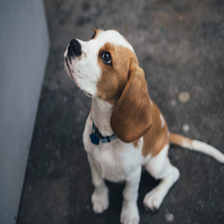

In [ ]:
sample2 = Im.open('/content/sample2.jpeg')
sample2_smol = sample2.resize((target_width, target_height))
sample2_smol

So now we got a cute doggo and a cute catto. So obviously if we just mash the images we can double the cuteness right

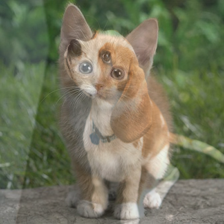

In [ ]:
l = 0.5

catto = np.array(sample_smol.getdata())
catto = catto.reshape((target_width, target_height, catto.shape[-1]))
doggo = np.array(sample2_smol.getdata())
doggo = doggo.reshape((target_width, target_height, doggo.shape[-1]))

wtf_o = (catto*l + (1-l)*doggo).astype(np.uint8)
Im.fromarray(wtf_o)

lol

Ok so maybe it's not that cute.  
However, notice how despite the blurring of fine-grained features such as fur, and the overall oddity of the image, u can still pick out features that make it appear like a dog or cat (see the legs) but not really one or the other  

Intuitively, mixup introduces extreme edge cases to the model to blur out its decision boundaries and hence condense the likelihood of positive predictions towards the actual sample distribution  

In english: show the model some messed up shit so it knows that stuff like that are defo not one label or another but just some nonsense

Take note that mix up, like any other augmentation technique, is going to completely depend on the context of your training objective.  

One example would be textual data, where applying mixup is obviously a terrible idea (doesn't mean u can't use mixup in nlp tho)

# Optional Activity

Try it out with these 2 images (just right click and save the image, dont double click the cells)  

HINT: check the number of channels in the first image compared to the 2nd image. Is the extra channel really necessary in this context? (See [alpha channel](https://www.makeuseof.com/tag/alpha-channel-images-mean/))

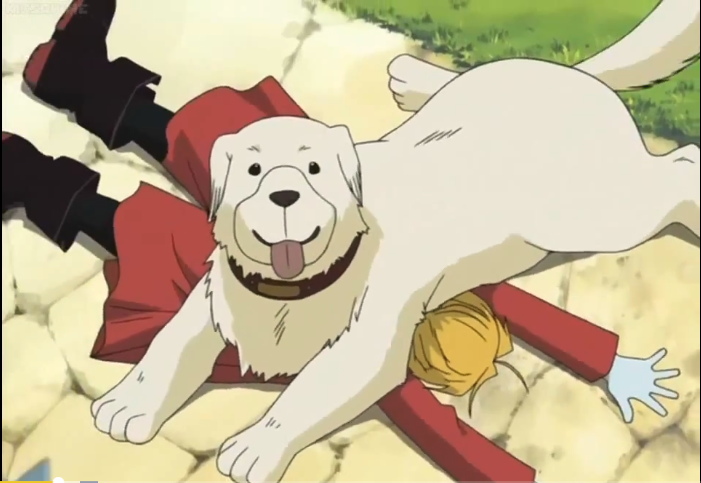

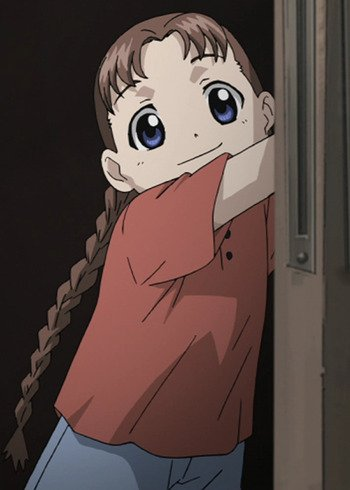